_Since we announced [our collaboration with the World Bank and more partners to create the Open Traffic platform](https://mapzen.com/blog/announcing-open-traffic/), we’ve been busy. We’ve shared [two](https://mapzen.com/blog/open-traffic-osmlr-technical-preview/) [technical](https://mapzen.com/blog/osmlr-2nd-technical-preview/) previews of the OSMLR linear referencing system. Now we’re ready to share more about how we’re using [Mapzen Map Matching](https://mapzen.com/blog/map-matching/) to “snap” GPS-derived locations to OSMLR segments, and how we’re using a data-driven approach to evaluate and improve the algorithms._

# A "data-driven" approach to improving map-matching, Part II

In the [last](https://mapzen.com/blog/map-matching-validation/) blog post on Mapzen's map-matching service, we showed you how Mapzen uses synthetic GPS data to validate the results of our map-matching algorithm. This time around, we'll dive a _bit_ deeper into the internals of the algorithm itself to see how we can use our validation metrics to fine-tune the map-matching parameters.

## 0. Setup test environment

In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
import numpy as np
import glob
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

#### User vars

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')
cityName = 'San Francisco'
numRoutes = 200

#### Load our old routes

Check out the last [notebook](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/33868a9703f9c00d42dd520339eac3ec04fb4ea0/notebooks/map_matching_part_I.ipynb) in this series if you don't have routes yet. Or just read along!

In [3]:
routeList = pickle.load(open('{0}_{1}_routes.pkl'.format(cityName, numRoutes), 'rb'))

## 1. Parameter Defintions

The Open Traffic Reporter map-matching service is based on the Hidden Markov Model (HMM) design of [Newson and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf). HMM's define a class of models that utilize a directed graph structure to represent the probability of observing a particular sequence of events -- or in our case, a particular sequence of road segments that defines a route. For our purposes, it is enough to know that  HMM's are, in general, governed by two probability distributions which we've parameterized using $\sigma_z$ and $\beta$, respectively. If, however, you are interested in a more detailed explanation of how HMM's work in the context of map-matching, please see the excellent map-matching primer [here](https://github.com/valhalla/meili/blob/master/docs/meili/algorithms.md) written by Mapzen's own routing experts.

![image](https://raw.githubusercontent.com/valhalla/meili/master/docs/meili/figures/model.png)
<center>*The graph structure of an HMM for an example route (from Mapzen's map-matching algorithms [primer](https://github.com/valhalla/meili/blob/master/docs/meili/algorithms.md))*</center>

### $\sigma_z$ 

The parameter $\sigma_z$ appears in the equation below which expresses the likelihood of recording a GPS measurement $z_t$ from road segment $r_i$ as the following Gaussian probability density function (PDF):

### $$ p(z_t|r_i) = \frac{1}{\sqrt{2 \pi \sigma_z}} e^{-0.5(\frac{||z_t - x_{t,i}||_{\text{great circle}}}{\sigma_z})^2}$$
where $x_{t,i}$ is the point on road segment $r_i$ nearest the measurement $z_t$ at time $t$.
In practice, $\sigma_z$ can be thought of as an estimate of the standard deviation of the GPS noise. The more we trust our measurements, the lower the value of our $\sigma_z$ should be. Newson and Krumm (2009) derive $\sigma_z$ from the median absolute deviation over their dataset, arriving at a value of **4.07**, which we have adopted as our default parameter value.

### $\beta$

The $\beta$ parameter comes from the following exponential PDF:

### $$p(d_t) = \frac{1}{\beta}e^{\frac{-d_t}{\beta}}$$

where $d_t$ is the difference between the great circle distance and route-traveled distance between time $t$ and $t+1$. We use an exponential PDF to define this probability because Newson and Krumm (2009) found that for two successive GPS measurements, the differences in length between the "great circle" distance (i.e. "as-the-crow-flies" distances) and the corresponding route-traveled distance are exponentially distributed.

<img src="newson_and_krumm_exp.png" alt="Drawing" width="40%" align="center"/>
<center><i>From Newson and Krumm (2009)</i></center>

In this context, $\beta$ can be thought of as the expected difference between great circle distances and route distance traveled. We would expect a higher $\beta$ value for more circuitous, less direct routes. We have adopted a $\beta$ of **3** as our default parameter value.

## 2. Grid search

Although we can empirically derive our parameter values using the equations above, we can also just search the space of feasible parameter values to find the ones that give the best results. This is a common machine learning approach for algorithm optimization, typically referred to as a **grid search** or parameter sweep. Grid search requires a reliable scoring mechanism in order to compare results. Lucky for us, we already implemented a number of these in our exploration of [validation](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/33868a9703f9c00d42dd520339eac3ec04fb4ea0/notebooks/map_matching_part_I.ipynb) metrics. 

Since we have to pick one to use in the grid search, we'll stick with Newson and Krumm's distance-based error metric for now, since it appears most frequently in the literature. Let's take a quick look back at what those errors looked like over our set of validation data:

<img src="newson_krumm_score.png" alt="Drawing" width="70%" align="center"/>

Clearly the quality of our data, by way of GPS noise and sample rate, has a huge impact on match error. Taking that into consideration, in addition to searching over the feasible space of $\beta$'s and $\sigma_z$'s, we'll want to iterate over different noise levels and sample rates so that we can optimize our map-matching regardless of the quality of the data we receive.

### a) Define the search space

Because this grid search takes place in such high dimensional space - $\text{noise levels} \times \text{sample rates} \times \beta \ \text{values} \times \sigma\  \text{values} \times \text{# routes}$ - it is recommended to use a smaller number of discrete noise levels for this section of the analysis (< 10).

In [4]:
noiseLevels = np.linspace(0, 100, 6)   # in meters
sampleRates = [1, 5, 10, 20, 30]   # in seconds
betas = np.linspace(0.5, 10, 20)   # no units
sigmas = np.linspace(0.5, 10, 20)    # no units

### b) Search and score

We've wrapped the entire grid search code into the `grid_search_hmm_params()` function since the internals are pretty messy. Behind the scenes, though, `grid_search_hmm_params()` proceeds as follows:

```for route in routes:
    for beta in betas:
        for sigma in sigmas:
            for noise in noiseLevels:
                for rate in sampleRates:
                    i) simulate gps
                    ii) match routes
                    iii) score the route
    write scores to a route-specific file
```

Depending on the dimensions of your search space, grid search can be a long and arduous process. In our case, on a 2015 MacBook Pro, it seems to take ~1 min. per route for a given noise level and sample rate. With the configuration specified above, that works out to roughly 30 minutes per route. While this runtime does indeed seem a bit absurd, the beauty of grid search is that if you properly define your search space, you should really only need to do it once. 

In [5]:
val.grid_search_hmm_params(cityName, routeList, sampleRates, noiseLevels, betas, sigmas)

## 3. Get optimal params

###  a) Combine the scores for all routes

Because of the slow runtime, `grid_search_hmm_params()` saves its results incrementally in route-specific files. We must first recombine them into a single master dataframe so that we can query, plot, and otherwise manipulate the data all together

In [6]:
frame = val.mergeCsvsToDataFrame(dataDir='../data/sf200/', matchString='*.csv')

The first five rows of the combined dataframe:

In [8]:
frame.head()

,sample_rate,noise,beta,sigma_z,score
0,1,0.0,0.5,0.5,0.000000
1,5,0.0,0.5,0.5,0.000000
2,10,0.0,0.5,0.5,0.000000
3,20,0.0,0.5,0.5,0.219928
4,30,0.0,0.5,0.5,0.219928


### b) Visualize scores

Now we visually can assess the parameter scores to check for global optima or tease out any other patterns that might persist across the various dimensions of our grid search. The `get_param_scores()` function will also return a dictionary of optimal parameter values corresponding to each one of the subplots below:

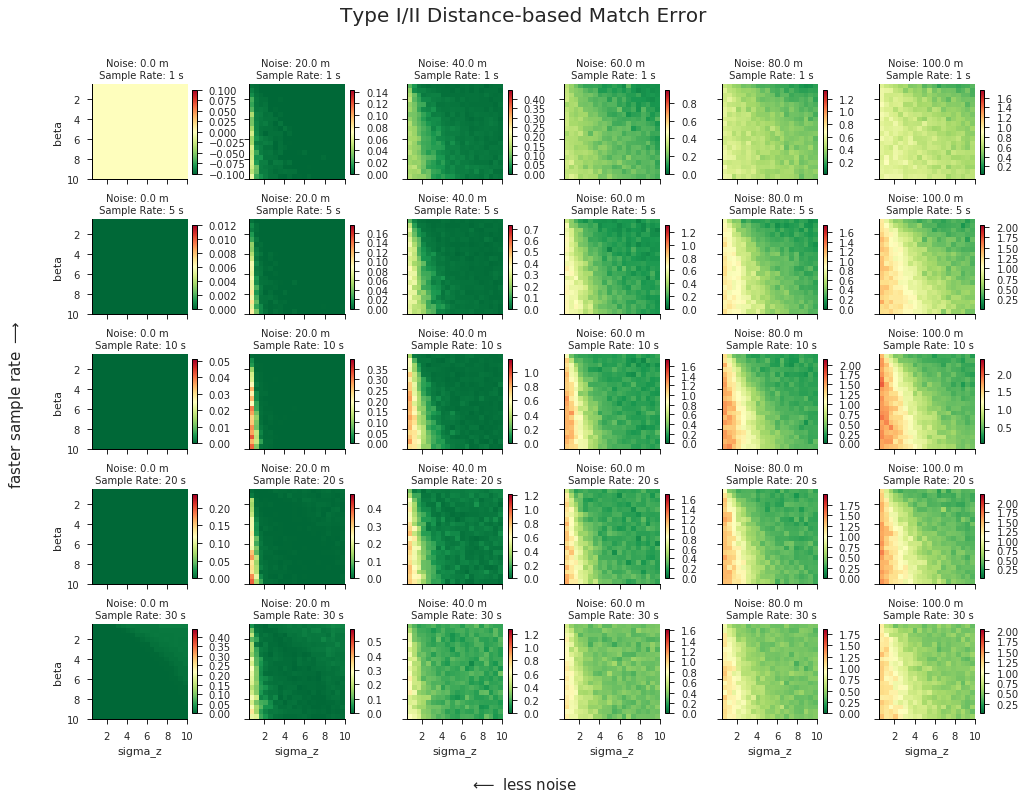

In [9]:
paramDict = val.get_param_scores(frame, sampleRates, noiseLevels, betas, sigmas, plot=True)

### c) Making sense of the results

In our case there does appear to be a "global" trend of decreasing error toward the upper right quadrants of our plots, which correspond to higher $\sigma_z$'s and lower $\beta$'s. If we wanted to optimize our parameters across all sample rates and noise levels at once, the results suggest that our optimal parameters would lie at the maximum $\sigma_z$ and minimum $\beta$ values of our search space. This is an interesting finding, and not entirely satistfying, since it is typically unwise to pick parameter values at the limits of your search space -- who knows what may lie on the other side? Although this could be evidence that we didn't cast a wide enough net in our parameter sweep, there is reason to believe that it might not be worthwhile to search any further:

1. Focusing specifically at the plots in the 0 - 40 m range of noise, it's pretty clear that expanding the range of feasible parameter values wouldn't do any good. **You can't get much better than 0 error, and our plots in this range are already dominated by dark green**. We can obtain optimal results by picking parameters anywhere in this dark green zone.
2. We expect most of our data to be within this bottom half of the range of noise levels we tested. According to the [Institute of Navigation](https://www.ion.org/publications/abstract.cfm?articleID=13079), GPS-enabled smartphones can typically achieve an accuracy of ~5 m. Even taking into consideration the fact that most of our Open Traffic partners will be operating in dense urban environments where GPS is notoriously inaccurate, we still expect to be operating primarily in the realm sub-60 m of noise. **It is likely not to our advantage to tune our algorithm parameters to optimize for the worst-case scenario**.
3. In the range of noiser data (> 60 m), although there is very _little_ dark green in the plots, there is also no evidence to suggest that we should expect to do any better by increasing our search space. In fact, our inuition about the limitations of map-matching with extremely noisy GPS data tells us that the opposite is probably true. **There is only so much we can expect the algorithm to do with data once its positional accuracy is less than the length of a standard city block.**
4. Grid search is over this many different parameters is extremely **slow**.

Taking these ideas into consideration, it is clear that expanding our search space would yield diminishing returns. Instead, we'll use the results we've already got to make a more informed decision about how we want to fine-tune our parameters. In the next section, we'll implement such an approach for one hypothetical transportation network company (TNC).

## 4. Case study: "A-OK Rides"

Mapzen's latest Open Traffic partner is a hypothetical TNC called **A-OK Rides**. A-OK Rides happens to be based in Singapore, and nearly 90% of A-OK trips either start or end in the city-state's central business district. Despite being located in one of the world's greatest hubs of technology and innovation, the A-OK app itself is a bit behind-the-times -- it only collects GPS measurements from A-OK drivers every 20 seconds. In this case study, we'll see how Mapzen can use this contextual information about our partner's service territory and anticipated data quality in order to improve our match results.

### a) Generate routes

In [10]:
cityName = 'Singapore'
singaporeRoutes = val.get_POI_routes_by_length('Singapore', 1, 5, 100, gmapsKey)

### b) Customizing our search space

Since we know that almost 90% of our GPS data will be generated from within an area dominated by skyscrapers and other forms of dense urban development, this _is_ a case where we actually want to optimize for noisier data. As such, we will perform our parameter sweep over routes generated with 60 m of noise:

In [12]:
noiseLevels = [60]    # meters

Similarly, since A-OK only collects data every 20 seconds, we can make sure we are only optimizing for data generated at this frequency:

In [13]:
sampleRates = [20]    # seconds

We'll search for our optimal $\beta$ and $\sigma_z$ values over the same space as before:

In [14]:
betas = np.linspace(0.5, 10, 20)
sigmas = np.linspace(0.5, 10, 20)

In [15]:
val.grid_search_hmm_params(cityName, singaporeRoutes, sampleRates, noiseLevels, betas, sigmas)

### c) Retrieve optimal params

In [16]:
paramDf = val.mergeCsvsToDataFrame(dataDir='../data/', matchString="Singapore*.csv")

In [22]:
paramDict = val.get_param_scores(paramDf, sampleRates, noiseLevels, betas, sigmas, plot=False)
sigma, beta = val.get_optimal_params(paramDict, sampleRateStr='20', noiseLevelStr='60')
print('Sigma: {0} // Beta: {1}'.format(sigma, beta))

Sigma: 7.0 // Beta: 9.0


### d) Get scores with optimal params

Generate new routes:

In [21]:
newRoutes = val.get_POI_routes_by_length('Singapore', 1, 5, 100, gmapsKey)

And score the matches using our tuned parameter values:

In [70]:
tunedDf, _, _ = val.get_route_metrics(newRoutes, sampleRates, noiseLevels, sigmaZ=sigma, beta=beta, saveResults=False)

### e) Compare to performance of default params

Regenerate matches on the same routes using the default parameter values:

In [69]:
defaultDf, _, _ = val.get_route_metrics(newRoutes, sampleRates, noiseLevels, sigmaZ=4.07, beta=3, saveResults=False)

Compare the before-and-after error distributions:

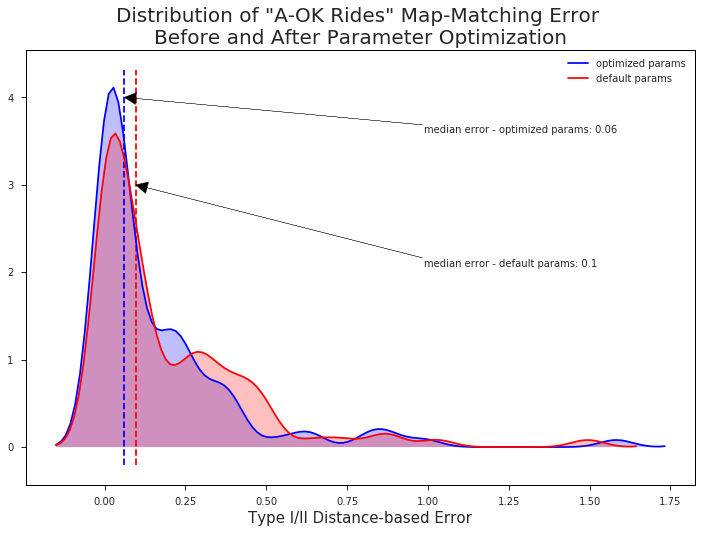

In [68]:
val.plot_err_before_after_optimization(defaultDf, tunedDf)

### f) Results

By tuning our map-matching parameters to fit the specific character of A-OK Rides' data, we were able to reduce our median error rate from 10% to 6%. Although it seems like our default parameter values weren't too far off the mark in this case, a 4% gain in median match accuracy can still have a huge impact on the overall performance of a near-real-time traffic platform like Open Traffic.

Most importantly, however, we've shown that **we have a realiable methodology for fine-tuning our map-matching service to meet the specific needs of our data providers, whoever -- and _whereever_ -- they may be**. 